Importing the libararies needed for linear algebra as well as reading a CSV file.

In [4]:
import spacy
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

Using the nlp library for determining the word role in a sentence. 

In [5]:
nlp = spacy.load('en_core_web_sm')

doc = nlp("Primary_use,day_of_week,day_of_month,season,meter,building_id,square_feet features are gained more forecasting importance by forward feature selection..")

for tok in doc:
    print(tok.text, "...", tok.dep_)

Primary_use ... ROOT
, ... punct
day_of_week ... npadvmod
, ... punct
day_of_month ... npadvmod
, ... punct
season ... npadvmod
, ... punct
meter ... conj
, ... punct
building_id ... appos
, ... punct
square_feet ... compound
features ... nsubjpass
are ... auxpass
gained ... ROOT
more ... amod
forecasting ... compound
importance ... dobj
by ... prep
forward ... amod
feature ... compound
selection ... pobj
.. ... punct


Installing the beautifulsoup4 library for NLP.

In [6]:
!pip install beautifulsoup4

Importing the libraries needed for NLP.

In [7]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

Reading the CSV file containing the results of the explanation.

In [8]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
import pandas as pd 

candidate_sentences = pd.read_csv("gdrive/My Drive/Results of explanation techniques.csv")
candidate_sentences.shape

(96, 1)

Defining a function that extracts the entities or the nodes from CSV file.

In [10]:
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""  # dependency tag of previous token in the sentence
    prv_tok_text = ""  # previous token in the sentence

    prefix = ""
    modifier = ""

    #############################################################

    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " " + tok.text
                prefix = prv_tok_text + " " + tok.text

            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " " + tok.text

            ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier + " " + prefix + " " + tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""

                ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier + " " + prefix + " " + tok.text

            ## chunk 5  
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
    #############################################################

    return [ent1.strip(), ent2.strip()]

Adding the extracted entities to an array.

In [11]:
entity_pairs = []

for i in tqdm(candidate_sentences["Results"]):
    entity_pairs.append(get_entities(i))

100%|██████████| 96/96 [00:01<00:00, 76.04it/s]


Extracting the relations from the extracted entities.

In [12]:
def get_relation(sent):

    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", None, pattern) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [ ]:
get_relation("season is one of the most effective features for consumption of energy")

'is'

In [ ]:
get_relation("weather and building_age are input features")

'are'

Assigning all the relations of the dataset to a variable.

In [13]:
relations = [get_relation(i) for i in tqdm(candidate_sentences["Results"])]

100%|██████████| 96/96 [00:01<00:00, 93.81it/s]


Assigning relations between the extracted features (nodes) and their relations (edges). 

In [14]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df['edge']

0            is
1       affects
2       affects
3          used
4          used
        ...    
91    concluded
92       reduce
93           is
94           is
95           is
Name: edge, Length: 96, dtype: object

In [15]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df['source']

0                        season
1     where the air conditioner
2     where the air conditioner
3                         meter
4                              
                ...            
91        the base temperatures
92                  square_feet
93                        meter
94                        month
95                 day_of_month
Name: source, Length: 96, dtype: object

In [16]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df['target']

0     effective  energy
1              building
2              building
3            94 an R2 %
4          94.2 an R2 %
            ...        
91       10 10 ° winter
92               1.2  %
93                     
94                     
95                     
Name: target, Length: 96, dtype: object

Showing the extracted edges from the CSV file.

In [17]:
kg_df['edge'].value_counts()

is                    26
are                   16
is important          15
affects                5
used for               4
mean                   3
reduce                 2
used as                2
affect                 2
contributed in         2
used                   2
affecting              1
needed                 1
compared               1
are optimal            1
increases due          1
decreases due          1
was                    1
improved by            1
sea_level_pressure     1
are important          1
improved               1
detected as            1
gained more            1
decreased              1
had                    1
has                    1
concluded              1
Name: edge, dtype: int64

Showing the extracted source nodes from the CSV file.

In [18]:
kg_df['source'].value_counts()

day_of_month                                                         6
meter                                                                5
                                                                     5
MSE                                                                  4
building_age                                                         4
square_feet                                                          4
season                                                               3
wind_speed                                                           3
air_temperature                                                      3
day_of_week                                                          3
weather                                                              3
site_id                                                              3
primary_use                                                          3
weather_condition                                                    2
cloud_

Showing the extracted target nodes from the CSV file.

In [19]:
kg_df['target'].value_counts()

                                         32
for energy forecasting                    6
final  prediction                         2
a regression model                        2
for feature extraction                    2
energy consumption forecasting            2
important  work                           2
building                                  2
for energy consumption                    2
environment                               1
of energy consumption                     1
important  features                       1
features                                  1
the consumption rate                      1
working  condition                        1
structure                                 1
for energy prediction                     1
effective  energy                         1
more  subclasses                          1
work                                      1
affect energy consumption                 1
22 22 ° summer                            1
the energy consumption          

Constructing a knowledge graph containing all the features and explanations..

In [20]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

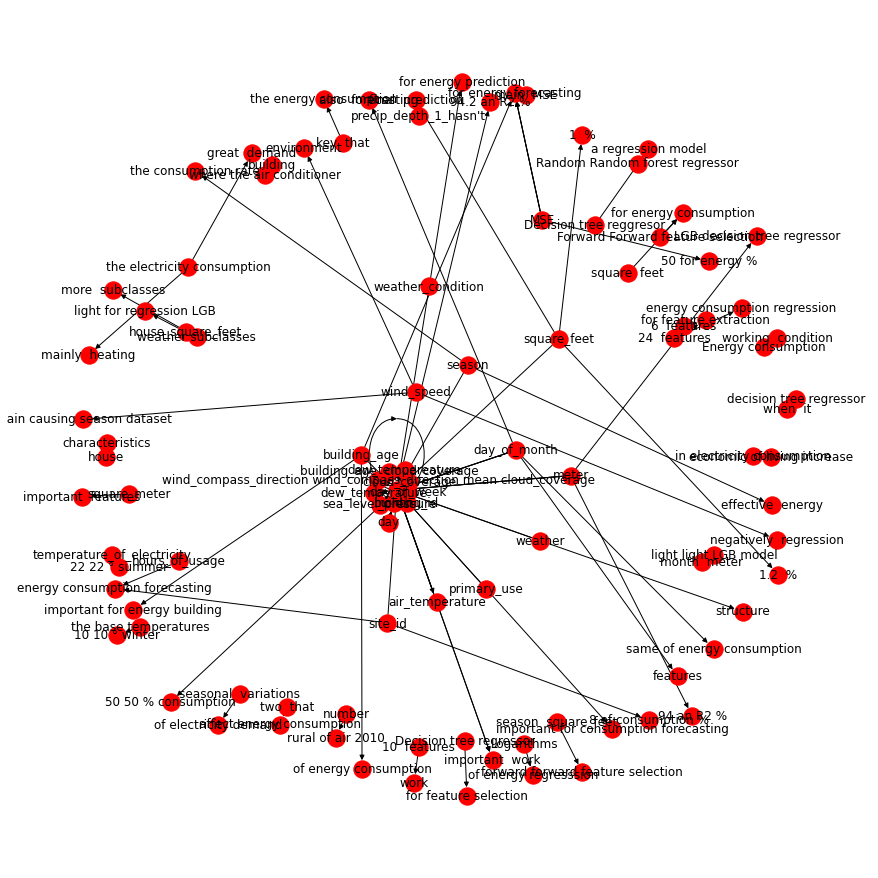

In [21]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Constructing a knowledge graph containing the most important features that are common between all techniques.

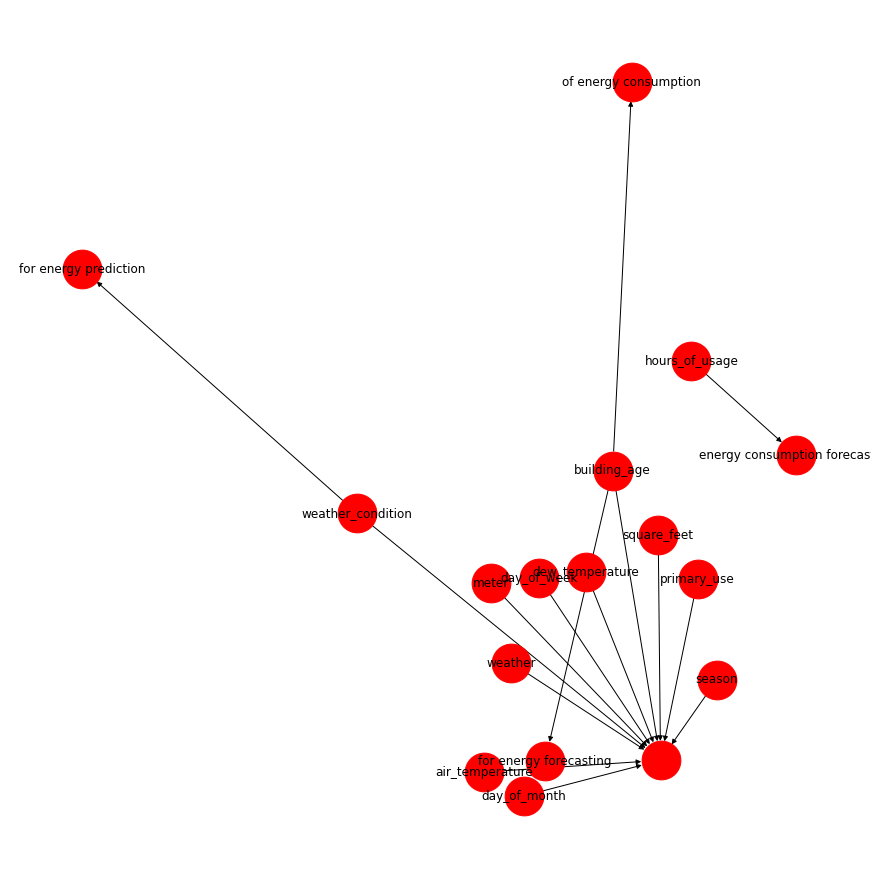

In [24]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="is important"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Constructing an ontology for querying the knowledge graph.

Shows the user the main categories of features in the dataset.

In [ ]:
@anvil.server.callable
def main_categories():
  print_variable = f"* The main categories are:\n\n1) Weather.\n2) Building."

  return print_variable
  
  anvil.server.wait_forever()

This function allows the user to query the knowledge graph based on a chosen category.

In [ ]:
import anvil.mpl_util

import numpy as np
import matplotlib.pyplot as plt

@anvil.server.callable
def category_subclasses(category):
    if category == "Weather":  
      G=nx.from_pandas_edgelist(kg_df[(kg_df['source']=="weather") | (kg_df['source']=="weather_condition") | (kg_df['source']=="cloud_coverage") | (kg_df['source']=="air_temperature") | (kg_df['source']=="seasonal  variations")
         | (kg_df['source']=="season") | (kg_df['source']=="wind_speed") | (kg_df['source']=="precip_depth_1_hr") | (kg_df['source']=="mean air_temperature") | (kg_df['source']=="mean sea_level_pressure")
         | (kg_df['source']=="mean precip_depth_1_hr") | (kg_df['source']=="hot_climate") | (kg_df['source']=="In summer") | (kg_df['source']=="In winter") | (kg_df['source']=="temperature_of_electricity and daily_temperature")
         | (kg_df['source']=="wind_compass_direction wind_compass_direction mean cloud_coverage") | (kg_df['source']=="dew_temperature") | (kg_df['source']=="the base temperatures") | (kg_df['source']=="temperature of electricity")],"edge", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
      plt.figure(figsize=(12,12))
      pos = nx.spring_layout(G, k = 0.6)
      nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
      plt.plot()   

      return anvil.mpl_util.plot_image()

      anvil.server.wait_forever()

    elif category == "Building":
      G=nx.from_pandas_edgelist(kg_df[(kg_df['source']=="building") | (kg_df['source']=="building_id") | (kg_df['source']=="building_age") | (kg_df['source']=="meter") 
      | (kg_df['source']=="square_feet") | (kg_df['source']=="month meter") | (kg_df['source']=="season square_feet") | (kg_df['source']=="house square_feet") | (kg_df['source']=="meter_square")
      | (kg_df['source']=="building_age  cloud_coverage")],"edge", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

      plt.figure(figsize=(12,12))
      pos = nx.spring_layout(G, k = 0.6)
      nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
      plt.plot()

      return anvil.mpl_util.plot_image()

      anvil.server.wait_forever()
  

This function returns a text explanation explaining the relations inside the graph generated from the previous function

In [ ]:
import anvil.mpl_util

import numpy as np
import matplotlib.pyplot as plt

@anvil.server.callable
def category_subclasses1(category):
   if category == "Weather":
      print_variable = f"* The following statements provide explanations for the relations within the graph:\n\n"
      print_variable += f"1) weather is important.\n2) weather_condition is important.\n3) season is one of the most effective features for consumption of energy." 
      print_variable += f"\n4) cloud_coverage is not important.\n5) temperature_of_electricity is 10Â°C in winter and 22Â°C in summer.\n6) sea_level_pressure and air_temperature are important features for work."
      print_variable += f"\n7) weather subclasses are more important than building subclasses.\n8) weather and cloud_coverage are input features.\n9) temperature_of_electricity and daily_temperature are 10Â°C in winter and 22Â°C in summer respectively."
      print_variable += f"\n10) hot_climate is one of the key factors that influence the energy consumption.\n11) winter and summer are the two seasons that affect energy consumption the most."
      print_variable += f"\n12) weather affects the features of the building's structure.\n13) wind_speed affects the environment." 
      print_variable += f"\n14) weather,weather_condition,season,air_temperature, and dew_temperature are all important features.\n15) weather_condition is important for energy prediction."
      print_variable += f"\n16) precip_depth_1_hr hasn't contributed in the final prediction."
      print_variable += f"\n17) The seasonal variations of electricity demand are compared to the temperature."  
      print_variable += f"\n18) wind_speed is detected as the main source of causing season change."
      print_variable += f"\n19) It is concluded that the base temperatures of electricity consumption reach 22Â°C in summer and are below 10Â°C in winter."

      return print_variable

      anvil.server.wait_forever()
   

   elif category == "Building":
      print_variable = f"* The following statements provide explanations for the relations within the graph:\n\n"
      print_variable += f"1) meter is the most important feature according to light GBM and decision tree regressor.\n2) meter is the best candidate for forecasting when it comes to the decision tree regressor."
      print_variable += f"\n3) site_id is not important for energy consumption forecasting.\n4) hours_of_usage is important for energy consumption forecasting."
      print_variable += f"\n5) house_square_feet is an important feature for regression model with the use of light GBM.\n6) building_id is the most important feature.\n7) month feature is very important."
      print_variable += f"\n8) day_of_month feature is very important.\n9) meter is the most important feature according to light GBM and decision tree regressor."
      print_variable += f"\n10) building_age is important for feature extraction of energy consumption.\n11) building_age is important for energy forecasting."
      print_variable += f"\n12) square_feet,season,air_temperature,and dew temperature are all important features.\n13) site_id,primary_use,and day_of_week are not so important."
      print_variable += f"\n14) primary_use is important.\nsquare_meter is the most important feature out of all building's features.\n15) day_of_month is one of the season's features."
      print_variable += f"\n16) Using building_age,the MSE for energy forecasting is 0.14.\n17) Using site_id,the MSE for energy forecasting is 3.99."
      print_variable += f"\n18) Using site_id as main cause,the MSE for energy forecasting is 3.86.\n19) Using site_id as a second main cause,the MSE for energy forecasting is 3.80."
      print_variable += f"\n20) building_age,primary_use,is_weekend,wind_speed,cloud_coverage,day_of_week are input features.\n21) primary_use,day_of_month,day_of_week,season,meter,building_id,and square_feet are the most important features for consumption forecasting."
      print_variable += f"\n22) meter,site_id, and building_age are the most important features for energy consumption of the building.\n23) building_id,month,and meter are most important faetures based on the light GBM model."
      print_variable += f"\n24) Number of days and months where the air conditioner is used affects the consumption of energy for a building.\n25) day_of_month is also affecting the forecasting."
      print_variable += f"\n26) building_age is important for energy forecasting.\n27) hours_of_usage is important for energy consumption forecasting."
      print_variable += f"\n28) both square_feet and primary_use are important features.\n29) both building_id and square_feet are important features."
      print_variable += f"\n30) meter and building_id can be used to predict the rate of consumption by an R2 score of 94%.\n31) meter,building_id, and day_of_month can be used to predict the rate of consumption by an R2 score of 94.2%."
      print_variable += f"\n32) square_feet hasn't contributed in the final prediction."
      print_variable += f"\n33) Due to the economic development and the improvement of living standards, an increase in electricity consumption is needed."
      print_variable += f"\n34) In summer, the electricity consumption utterly increases due to the great demand on cooling."
      print_variable += f"\n35) In winter, the electricity consumption decreases due the demand being mainly dependant on heating.\n36) square_feet reduces the accuracy of forecasting by 1%."
      print_variable += f"\n37) The number of air conditioners per 100 households was 200 in urban and 147 in rural area in 2010."
      print_variable += f"\n38) primary_use,day_of_week,day_of_month,season,meter,building_id,square_feet gained more forecasting importance by forward feature selection."
      print_variable += f"\n39) Using building_age,the MSE for energy forecasting has improved."
      print_variable += f"\n40) Using building_age,the MSE for energy forecasting has improved by 50%."
      print_variable += f"\n41) day_of_month,season,meter,building_id,and square_feet had the same effect on the rate of energy consumption."

      return print_variable

      anvil.server.wait_forever()

   #elif category != "Weather" or category != "Building":
     #print_variable = "Please choose a category."

     #return print_variable   


Returning all the source nodes that are encoded within the knowledge graph to the user.

In [ ]:
@anvil.server.callable
def all_source_nodes():
  print_variable = f"* The available source nodes are:\n\n"
  print_variable += f"1) day_of_month.\n2) meter.\n3) MSE.\n4) building_age.\n5) square_feet.\n6) season.\n7) wind_speed.\n8) air_temperature."
  print_variable += f"\n9) day_of_week.\n10) weather.\n11) site_id.\n12) primary_use.\n13) weather_condition.\n14) cloud_coverage.\n15) 24  features.\n16) the electricity consumption.\n17) where the air conditioner."
  print_variable += f"\n18) building_id.\n19) month.\n20) main  MSE.\n21) hours_of_usage.\n22) square_meter.\n23) square  feet.\n24) seasonal  variations.\n25) number.\n26) economic of living increase.\n27) key  that.\n28) temperature_of_electricity."
  print_variable += f"\n29) two  that.\n30) 10  features.\n31) 6  features.\n32) sea_level_pressure.\n33) wind_compass_direction wind_compass_direction mean cloud_coverage.\n34) building_age  cloud_coverage."
  print_variable += f"\n35) Energy consumption.\n36) precip_depth_1_hasn't.\n37) month  meter.\n38) weather subclasses.\n39) characteristics.\n40) season  square_feet.\n41) when  it.\n42) dew_tempereature."
  print_variable += f"\n43) Decision tree regressor.\n44) dew_temperature.\n45) day.Random Random forest regressor.\n46) house_square_feet.\n47) Forward Forward feature selection.\n48) Logarithms.\n49) the base temperature."
 
  return print_variable

  anvil.server.wait_forever()

Returning all the target nodes that are encoded within the knowledge graph to the user.

In [ ]:
@anvil.server.callable
def all_target_nodes():
  print_variable = f"* The available target nodes are:\n\n"
  print_variable += f"1) for energy forecasting.\n2) final  prediction.\n3) a regression model.\n4) for feature extraction.\n5) energy consumption forecasting.\n6) important  work."
  print_variable += f"\n7) building.\n8) for energy consumption.\n9) environment.\n10) of energy consumption\n11) important  features.\n12) features.\n13) the consumption rate."
  print_variable += f"\n14) working  condition.\n15) structure.\n16) for energy prediction.\n17) effective  energy.\n18) more  subclasses.\n19) work.\n20) affect energy consumption."
  print_variable += f"\n21) 22 22 ° summer.\n22) the energy consumption.\n23) in electricity consumption.\n24) rural of air 2010.\n25) of electricity demand.\n26) great  demand."
  print_variable += f"\n27) mainly  heating.\n28) 10 10 ° winter.\n29) also  forecasting.\n30) month.\n31) house.\n32) negatively  regression.\n33) 94 an R2 %.\n34) 94.2 an R2 %."
  print_variable += f"\n35) 50 50 % consumption.\n36) same of energy consumption.\n37) important for consumption forecasting.\n38) 8 of consumption %.\n39) 1  %."
  print_variable += f"\n40) forward forward feature selection.\n41) main causing season dataset.\n42) decision tree regressor .\n43) for feature selection."
  print_variable += f"\n44) important for energy building.\n45) 50 for energy %.\n46) light light LGB model.\n47) LGB decision tree regressor.\n48) energy consumption regression."
  print_variable += f"\n49) of energy regresssion.\n50) light for regression LGB.\n51) air_temperature.\n52) 1.2  %."  

  return print_variable

  anvil.server.wait_forever()

Returning to the user every keyword or edge existing inside knowledge graph.

In [ ]:
@anvil.server.callable
def all_keywords():
  print_variable = f"* The available edges are:\n\n"
  print_variable += f"1) important.\n2) affects.\n3) contributed in.\n4) detected as.\n5) concluded.\n6) used.\n7) needed.\n8) increased.\n9) decreased.\n10) is.\n11) are.\n12) was.\n13) has.\n14) gained\n15) improved."

  return print_variable

  anvil.server.wait_forever()



This function allows the user to query the knowledge graph based on a chosen keyword. 

In [ ]:
import anvil.mpl_util

import numpy as np
import matplotlib.pyplot as plt

@anvil.server.callable
def relations_based_on_keyword(keyword):
  if keyword == "is":
      G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="is"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
      plt.figure(figsize=(12,12))
      pos = nx.spring_layout(G, k = 0.5)
      nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
      plt.plot()

      return anvil.mpl_util.plot_image()

      anvil.server.wait_forever()

  elif keyword == "are":
      G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="are"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
      plt.figure(figsize=(12,12))
      pos = nx.spring_layout(G, k = 0.5)
      nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
      plt.plot() 

      return anvil.mpl_util.plot_image()

      anvil.server.wait_forever()
      

  elif keyword == "affects":
      G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="affects"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
      plt.figure(figsize=(12,12))
      pos = nx.spring_layout(G, k = 0.5)
      nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
      plt.plot()  

      return anvil.mpl_util.plot_image()

      anvil.server.wait_forever()
 
  elif keyword == "important":
      G=nx.from_pandas_edgelist(kg_df[(kg_df['edge']=="is important") | (kg_df['edge']=="are important")], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
      plt.figure(figsize=(12,12))
      pos = nx.spring_layout(G, k = 0.5)
      nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
      plt.plot()

      return anvil.mpl_util.plot_image()

      anvil.server.wait_forever()


  elif keyword == "used":
      G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="used"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
      plt.figure(figsize=(12,12))
      pos = nx.spring_layout(G, k = 0.5)
      nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
      plt.plot()  

      return anvil.mpl_util.plot_image()

      anvil.server.wait_forever()

  elif keyword == "contributed in":
      G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="contributed in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
      plt.figure(figsize=(12,12))
      pos = nx.spring_layout(G, k = 0.5)
      nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
      plt.plot() 

      return anvil.mpl_util.plot_image()

      anvil.server.wait_forever()

  elif keyword == "increased":
      G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="increases due"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
      plt.figure(figsize=(12,12))
      pos = nx.spring_layout(G, k = 0.5)
      nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
      plt.plot() 

      return anvil.mpl_util.plot_image()

      anvil.server.wait_forever()
      
  elif keyword == "decreased":
      G=nx.from_pandas_edgelist(kg_df[(kg_df['edge']=="decreased") | (kg_df['edge']=="reduce")], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
      plt.figure(figsize=(12,12))
      pos = nx.spring_layout(G, k = 0.5)
      nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
      plt.plot() 

      return anvil.mpl_util.plot_image()

      anvil.server.wait_forever()
 
  elif keyword == "optimal":
      G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="are optimal"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
      plt.figure(figsize=(12,12))
      pos = nx.spring_layout(G, k = 0.5)
      nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
      plt.plot() 

      return anvil.mpl_util.plot_image()

      anvil.server.wait_forever()

  elif keyword == "was":
      G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="was"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
      plt.figure(figsize=(12,12))
      pos = nx.spring_layout(G, k = 0.5)
      nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
      plt.plot() 

      return anvil.mpl_util.plot_image()  

      anvil.server.wait_forever()

  elif keyword == "has":
      G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="has"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
      plt.figure(figsize=(12,12))
      pos = nx.spring_layout(G, k = 0.5)
      nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
      plt.plot()

      return anvil.mpl_util.plot_image()

      anvil.server.wait_forever()


  elif keyword == "detected as":
      G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="detected as"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
      plt.figure(figsize=(12,12))
      pos = nx.spring_layout(G, k = 0.5)
      nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
      plt.plot() 

      return anvil.mpl_util.plot_image()

      anvil.server.wait_forever()

  elif keyword == "needed":
      G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="needed"],"source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
      plt.figure(figsize=(12,12))
      pos = nx.spring_layout(G, k = 0.5)
      nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
      plt.plot()  

      return anvil.mpl_util.plot_image()   

      anvil.server.wait_forever()

  elif keyword == "gained":
      G=nx.from_pandas_edgelist(kg_df[(kg_df['edge']=="gained more")],"source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
      plt.figure(figsize=(12,12))
      pos = nx.spring_layout(G, k = 0.5)
      nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
      plt.plot()  

      return anvil.mpl_util.plot_image()

      anvil.server.wait_forever()    

  elif keyword == "improved":
      G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="improved"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
      plt.figure(figsize=(12,12))
      pos = nx.spring_layout(G, k = 0.5)
      nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
      plt.plot() 

      return anvil.mpl_util.plot_image()

      anvil.server.wait_forever()
  
  elif keyword == "concluded":
      G=nx.from_pandas_edgelist(kg_df[(kg_df['edge']=="concluded") | (kg_df['edge']=="are") & (kg_df['source']=="temperature_of_electricity")], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
      plt.figure(figsize=(12,12))
      pos = nx.spring_layout(G, k = 0.5)
      nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
      plt.plot()   

      return anvil.mpl_util.plot_image()  

      anvil.server.wait_forever()    

This function returns a text explanation for the relations inside the graph generated from the previous function.

In [ ]:
import anvil.mpl_util

import numpy as np
import matplotlib.pyplot as plt

@anvil.server.callable
def relations_based_on_keyword1(keyword):
   if keyword == "is":
      print_variable = f"* The following statements provide explainations for the relations within the graph:\n\n"
      print_variable += f"1) weather is important.\n2) weather_condition is important.\n3) season is one of the most effective features for consumption of energy.\n4) cloud_coverage is not important.\n5) temperature_of_electricity is 10Â°C in winter and 22Â°C in summer.\n6) sea_level_pressure and air_temperature are important features for work."
      print_variable += f"\n7) meter is the most important feature according to light GBM and decision tree regressor.\n8) meter is the best candidate for forecasting when it comes to the decision tree regressor.\n9) site_id is not important for energy consumption forecasting.\n10) hours_of_usage is important for energy consumption forecasting."
      print_variable += f"\n11) house_square_feet is an important feature for regression model with the use of light GBM.\n12) building_id is the most important feature.\n13) month feature is very important.\n14) day_of_month feature is very important.\nmeter is the most important feature according to light LGB and decision tree regressor."
      print_variable += f"\n15) building_age is important for feature extraction of energy consumption.\n16) building_age is important for energy forecasting.\n17) square_feet,season,air_temperature,and dew temperature are all important features.\n18) site_id,primary_use,and day_of_week are not so important.\n19) primary_use is important."
      print_variable += f"\n20) square_meter is the most important feature out of all building's features.\n21) day_of_month is one of the season's features.\nUsing building_age,the MSE for energy forecasting is 0.14.\n23) Using site_id,the MSE for energy forecasting is 3.99."
      print_variable += f"\n24) Using site_id as main cause,the MSE for energy forecasting is 3.86.\n25) Using site_id as a second main cause,the MSE for energy forecasting is 3.80."

      return print_variable

      anvil.server.wait_forever()
  
   elif keyword == "are":
      print_variable = f"* The following statements provide explainations for the relations within the graph:\n\n"
      print_variable += f"1) Weather subclasses are more important than building subclasses.\n2) weather and cloud_coverage are input features.\n3) temperature_of_electricity and daily_temperature are 10Â°C in winter and 22Â°C in summer respectively."
      print_variable += f"\n4) hot_climate is one of the key factors that influence the energy consumption.\n5) winter and summer are the two seasons that affect energy consumption the most."
      print_variable += f"\n6) building_age,primary_use,is_weekend,wind_speed,cloud_coverage,day_of_week are input features.\n7) primary_use,day_of_month,day_of_week,season,meter,building_id,and square_feet are the most important features for consumption forecasting."
      print_variable += f"\n8) meter,site_id, and building_age are the most important features for energy consumption of the building.\n9) building_id,month,and meter are most important faetures based on the light GBM model."
      
      return print_variable

      anvil.server.wait_forever()

   elif keyword == "affects":
      print_variable = f"* The following statements provide explainations for the relations within the graph:\n\n"
      print_variable += f"1) The weather feature affects the features of the building's structure.\n2) wind_speed affects the environment."
      print_variable += f"\n3) Energy consumption affects the working condition.\n4) Number of days where the air conditioner is used affects the consumption of energy for a building."
      return print_variable

      anvil.server.wait_forever()

   elif keyword == "important":
      print_variable = f"* The following statements provide explainations for the relations within the graph:\n\n"
      print_variable += f"1) weather,weather_condition,season,air_temperature, and dew_temperature are all important features.\n2) weather_condition is important for energy prediction."
      print_variable += f"\n3) building_age is important for energy forecasting.\n4) hours_of_usage is important for energy consumption forecasting."
      print_variable += f"\n5) both square_feet and primary_use are important features."
      print_variable += f"\n6) both building_id and square_feet are important features.\n7) mean air_temperature and sea_level_pressure are important features for work."
      
      return print_variable

      anvil.server.wait_forever()

   elif keyword == "used":
      print_variable = f"* The following statement provide explainations for the relations within the graph:\n\n"
      print_variable += f"- meter can be used to predict the rate of consumption by an R2 score ranging between 94% and 94.2%."

      return print_variable

      anvil.server.wait_forever()

   elif keyword == "contributed in":
     print_variable = f"* The following statements provide explainations for the relations within the graph:\n\n"
     print_variable += f"1) precip_depth_1_hr hasn't contributed in the final prediction." 
     print_variable += f"\n2) square_feet hasn't contributed in the final prediction."

     return print_variable

     anvil.server.wait_forever()

   elif keyword == "increased":
     print_variable = f"* The following statement provide explainations for the relations within the graph:\n\n"
     print_variable += f"- In summer, the electricity consumption utterly increases due to the great demand on cooling." 
     
     return print_variable

     anvil.server.wait_forever()

   elif keyword == "decreased":
     print_variable = f"* The following statements provide explainations for the relations within the graph:\n\n"
     print_variable += f"1) In winter, the electricity consumption decreases due the demand being mainly dependant on heating."
     print_variable += f"\n2) square_feet reduces the accuracy of forecasting within a range of 1% to 1.2%.\n3) site_id has decreased the rate of consumption prediction by 8%."

     return print_variable

     anvil.server.wait_forever()

   elif keyword == "optimal":  
     print_variable = f"* The following statement provide explainations for the relations within the graph:\n\n" 
     print_variable += f"- 6 features are optimal for feature extraction."

     return print_variable

     anvil.server.wait_forever()

   elif keyword == "was":  
     print_variable = f"* The following statements provide explainations for the relations within the graph:\n\n"
     print_variable += f"- The number of air conditioners per 100 households was 200 in urban and 147 in rural area in 2010."

     return print_variable

     anvil.server.wait_forever()

   elif keyword == "has":  
     print_variable = f"* The following statement provide explainations for the relations within the graph:\n\n"
     print_variable += f"- Using building_age,the MSE for energy forecasting has improved by 50%."

     return print_variable

     anvil.server.wait_forever()


   elif keyword == "detected as":
     print_variable = f"* The following statement provide explainations for the relations within the graph:\n\n"
     print_variable += f"- wind_speed is detected as the main source of causing season change."

     return print_variable  

     anvil.server.wait_forever()

   elif keyword == "needed":
     print_variable = f"* The following statement provide explainations for the relations within the graph:\n\n"
     print_variable += f"- Due to the economic development and the improvement of living standards, an increase in electricity consumption is needed."

     return print_variable

     anvil.server.wait_forever()

   elif keyword == "gained":
     print_variable = f"* The following statement provide explainations for the relations within the graph:\n\n"
     print_variable += f"- season and square_feet gained more forecasting importance by forward feature selection." 

     return print_variable

     anvil.server.wait_forever()


   elif keyword == "improved":
     print_variable = f"* The following statement provide explainations for the relations within the graph:\n\n"
     print_variable += f"1) Using building_age,the MSE for energy forecasting has improved." 

     return print_variable

     anvil.server.wait_forever()

   elif keyword == "concluded":
     print_variable = f"* The following statement provide explainations for the relations within the graph:\n\n"
     print_variable += f"- It is concluded that the base temperatures of electricity consumption reach 22Â°C and 10Â°C during summer and winter respectively."

     return print_variable

     anvil.server.wait_forever()

   

This function that allows the user to query the knowledge graph based on a certain category as well as a certain keyword.

In [ ]:
import anvil.mpl_util

import numpy as np
import matplotlib.pyplot as plt

@anvil.server.callable


def query(category,keyword):
   if category == "Weather":
     if keyword == "is":
        G=nx.from_pandas_edgelist(kg_df[((kg_df['edge']=="is") & (kg_df['source']=="season") | (kg_df['edge']=="is important") & (kg_df['source']=="weather_condition") | (kg_df['edge']=="is important") & (kg_df['source']=="season") 
        | (kg_df['edge']=="is important") & (kg_df['source']=="air_temperature") | (kg_df['edge']=="is important") & (kg_df['source']=="dew_temperature") | 
        (kg_df['edge']=="is important") & (kg_df['source']=="weather") | (kg_df['edge']=="are") & (kg_df['source']=="cloud_coverage") | (kg_df['edge']=="are") & (kg_df['source']=="temperature_of_electricity")
        | (kg_df['edge']=="mean") & (kg_df['source']=="air_temperature"))],"source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
        plt.figure(figsize=(12,12))
        pos = nx.spring_layout(G, k = 0.5)
        nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
        plt.plot()

        return anvil.mpl_util.plot_image() 

        anvil.server.wait_forever()


     elif keyword == "are":
        G=nx.from_pandas_edgelist(kg_df[(kg_df['edge']=="are") & (kg_df['source']=="weather subclasses") | (kg_df['edge']=="are") & (kg_df['source']=="weather_condition") | (kg_df['edge']=="are") & (kg_df['source']=="temperature_of_electricity")
        | (kg_df['edge']=="are") & (kg_df['source']=="hot_climate")],"source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
        plt.figure(figsize=(12,12))
        pos = nx.spring_layout(G, k = 0.5)
        nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
        plt.plot()

        return anvil.mpl_util.plot_image()  

        anvil.server.wait_forever() 


     elif keyword == "affects":
        G=nx.from_pandas_edgelist(kg_df[(kg_df['edge']=="affect") & (kg_df['source']=="weather") | (kg_df['edge']=="affects") & (kg_df['source']=="wind_speed")],"source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
        plt.figure(figsize=(12,12))
        pos = nx.spring_layout(G, k = 0.5)
        nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
        plt.plot()

        return anvil.mpl_util.plot_image() 

        anvil.server.wait_forever()


     elif keyword == "important":
        G=nx.from_pandas_edgelist(kg_df[(kg_df['edge']=="is important") & (kg_df['source']=="season") | (kg_df['edge']=="is important") & (kg_df['source']=="air_temperature") | (kg_df['edge']=="is important") & (kg_df['source']=="dew_temperature")],"source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
        plt.figure(figsize=(12,12))
        pos = nx.spring_layout(G, k = 0.5)
        nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
        plt.plot()

        return anvil.mpl_util.plot_image() 

        anvil.server.wait_forever()


     elif keyword == "contributed in":
        G=nx.from_pandas_edgelist(kg_df[(kg_df['edge']=="contributed in") & (kg_df['source']=="precip_depth_1_hasn't")],"source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
        plt.figure(figsize=(12,12))
        pos = nx.spring_layout(G, k = 0.5)
        nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
        plt.plot() 

        return anvil.mpl_util.plot_image() 

        anvil.server.wait_forever()

          
     elif keyword == "detected as":
        G=nx.from_pandas_edgelist(kg_df[(kg_df['edge']=="detected as")],"source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
        plt.figure(figsize=(12,12))
        pos = nx.spring_layout(G, k = 0.5)
        nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
        plt.plot()  

        return anvil.mpl_util.plot_image()

        anvil.server.wait_forever()


     elif keyword == "concluded":
        G=nx.from_pandas_edgelist(kg_df[(kg_df['edge']=="concluded")],"source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
        plt.figure(figsize=(12,12))
        pos = nx.spring_layout(G, k = 0.5)
        nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
        plt.plot()  

        return anvil.mpl_util.plot_image()

        anvil.server.wait_forever()


      #elif self.category_dropdown.selected_value == "Weather" and (keyword != "is"
        #or keyword != "are" or keyword != "affects"
        #or keyword != "important" or keyword != "contributed in" 
        #or keyword != "average" or keyword != "compared"
        #or keyword != "detected as" or keyword != "concluded"):  
          #if (keyword != "used" or keyword != "needed" 
              #or keyword != "increased" or keyword != "decreased" 
              #or keyword != "was" or keyword != "has"
              #or keyword != "had" or keyword != "gained"
              #or keyword != "improved"):

   elif category == "Building": 

      if keyword == "is": 
           G=nx.from_pandas_edgelist(kg_df[(kg_df['edge']=="is") & (kg_df['source']=="meter") | (kg_df['edge']=="is") & (kg_df['source']=="site_id") | (kg_df['edge']=="is") & (kg_df['source']=="house_square_feet") | (kg_df['edge']=="is") & (kg_df['source']=="primary_use")
           |(kg_df['edge']=="is") & (kg_df['source']=="building_id") | (kg_df['edge']=="is") & (kg_df['source']=="month") | (kg_df['edge']=="is") & (kg_df['source']=="day") | (kg_df['edge']=="is important") & (kg_df['source']=="hours_of_usage") | (kg_df['edge']=="is") & (kg_df['source']=="day_of_week")
           |(kg_df['edge']=="is important") & (kg_df['source']=="building_age") | (kg_df['edge']=="is important") & (kg_df['source']=="square_feet") | (kg_df['edge']=="is important") & (kg_df['source']=="season") | (kg_df['edge']=="is important") & (kg_df['source']=="air_temperature")
           |(kg_df['edge']=="is important") & (kg_df['source']=="dew_temperature") | (kg_df['edge']=="is") & (kg_df['source']=="day_of_month") | (kg_df['edge']=="is") & (kg_df['source']=="MSE") | (kg_df['edge']=="is") & (kg_df['source']=="main MSE") ],"source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
           plt.figure(figsize=(12,12))
           pos = nx.spring_layout(G, k = 0.5)
           nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
           plt.plot()

           return anvil.mpl_util.plot_image()  

           anvil.server.wait_forever()


      elif keyword == "are":
           G=nx.from_pandas_edgelist(kg_df[(kg_df['edge']=="are") & (kg_df['source']=="primary_use") | (kg_df['edge']=="are") & (kg_df['source']=="building_age") | (kg_df['edge']=="are") & (kg_df['source']=="month meter") ],"source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
           plt.figure(figsize=(12,12))
           pos = nx.spring_layout(G, k = 0.5)
           nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
           plt.plot()

           return anvil.mpl_util.plot_image() 

           anvil.server.wait_forever() 


      elif keyword == "affects":
           G=nx.from_pandas_edgelist(kg_df[(kg_df['edge']=="affects") & (kg_df['source']=="where the air conditioner") | (kg_df['edge']=="affecting") & (kg_df['source']=="day_of_month")],"source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
           plt.figure(figsize=(12,12))
           pos = nx.spring_layout(G, k = 0.5)
           nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
           plt.plot()

           return anvil.mpl_util.plot_image() 

           anvil.server.wait_forever() 


      elif keyword == "important":
           G=nx.from_pandas_edgelist(kg_df[(kg_df['edge']=="is important") & (kg_df['source']=="building_age") | (kg_df['edge']=="is important") & (kg_df['source']=="house_of_usage") | (kg_df['edge']=="is important") & (kg_df['source']=="square_feet")
           |(kg_df['edge']=="is important") & (kg_df['source']=="building_id") | (kg_df['edge']=="is important") & (kg_df['source']=="meter") | (kg_df['edge']=="are important") & (kg_df['source']=="building_id") | (kg_df['edge']=="are important") & (kg_df['source']=="house_of_usage") | (kg_df['edge']=="are important") & (kg_df['source']=="square_feet")
           |(kg_df['edge']=="are important") & (kg_df['source']=="building_id") | (kg_df['edge']=="are important") & (kg_df['source']=="meter")],"source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
           plt.figure(figsize=(12,12))
           pos = nx.spring_layout(G, k = 0.5)
           nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
           plt.plot()

           return anvil.mpl_util.plot_image()    

           anvil.server.wait_forever() 


      elif keyword == "used":
           G=nx.from_pandas_edgelist(kg_df[(kg_df['edge']=="used") | (kg_df['source']=="meter")],"source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
           plt.figure(figsize=(12,12))
           pos = nx.spring_layout(G, k = 0.5)
           nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
           plt.plot() 

           return anvil.mpl_util.plot_image() 

           anvil.server.wait_forever()

           
      elif keyword == "contributed in":
           G=nx.from_pandas_edgelist(kg_df[(kg_df['edge']=="contributed in") & (kg_df['source']=="square_feet")],"source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
           plt.figure(figsize=(12,12))
           pos = nx.spring_layout(G, k = 0.5)
           nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
           plt.plot() 

           return anvil.mpl_util.plot_image() 

           anvil.server.wait_forever()


      elif keyword == "needed":
           G=nx.from_pandas_edgelist(kg_df[(kg_df['edge']=="needed")],"source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
           plt.figure(figsize=(12,12))
           pos = nx.spring_layout(G, k = 0.5)
           nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
           plt.plot() 

           return anvil.mpl_util.plot_image() 

           anvil.server.wait_forever()

                 
      elif keyword == "increased":
           G=nx.from_pandas_edgelist(kg_df[(kg_df['edge']=="increases due")],"source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
           plt.figure(figsize=(12,12))
           pos = nx.spring_layout(G, k = 0.5)
           nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
           plt.plot()

           return anvil.mpl_util.plot_image()  

           anvil.server.wait_forever()

             
      elif keyword == "decreased":
           G=nx.from_pandas_edgelist(kg_df[(kg_df['edge']=="decreases due") | (kg_df['edge']=="reduce")],"source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
           plt.figure(figsize=(12,12))
           pos = nx.spring_layout(G, k = 0.5)
           nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
           plt.plot() 

           return anvil.mpl_util.plot_image() 

           anvil.server.wait_forever()

                       
      elif keyword == "was":
           G=nx.from_pandas_edgelist(kg_df[(kg_df['edge']=="was")],"source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
           plt.figure(figsize=(12,12))
           pos = nx.spring_layout(G, k = 0.5)
           nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
           plt.plot()

           return anvil.mpl_util.plot_image() 

           anvil.server.wait_forever()

                    
      elif keyword == "gained":
           G=nx.from_pandas_edgelist(kg_df[(kg_df['edge']=="gained more")],"source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
           plt.figure(figsize=(12,12))
           pos = nx.spring_layout(G, k = 0.5)
           nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
           plt.plot()  

           return anvil.mpl_util.plot_image()

           anvil.server.wait_forever()


      elif keyword == "improved":
           G=nx.from_pandas_edgelist(kg_df[(kg_df['edge']=="improved") | (kg_df['edge']=="improved by")],"source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
           plt.figure(figsize=(12,12))
           pos = nx.spring_layout(G, k = 0.5)
           nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
           plt.plot() 

           return anvil.mpl_util.plot_image()

           anvil.server.wait_forever()
     

      elif keyword == "has":
           G=nx.from_pandas_edgelist(kg_df[(kg_df['edge']=="has")],"source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
           plt.figure(figsize=(12,12))
           pos = nx.spring_layout(G, k = 0.5)
           nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
           plt.plot() 

           return anvil.mpl_util.plot_image()

           anvil.server.wait_forever()

        

      #elif (keyword != "is" or keyword != "are" or keyword != "affect" or keyword != "affects" or keyword != "affecting" or keyword != "is important" or keyword != "are important"
           #or keyword != "important" or keyword != "used" or keyword != "reduce" or keyword != "contributed in" or keyword != "contributed"
           #or keyword != "needed" or keyword != "increases due" or keyword != "decreases due" or keyword != "decreased" or keyword != "was" 
           #or keyword != "gained more" or keyword != "gained" or keyword != "improved" or keyword != "improved by" or keyword != "has" or keyword != "had"):  
             #if (keyword != "mean" or keyword != "compared" or keyword != "sea_level_pressure" or keyword != "detected as" or keyword != "concluded"):
                #print_variable = f"There are no relations between the chosen category and the chosen keyword."
                #print(f"There are no relations between the chosen category and the chosen keyword.") 
                #return print_variable

             #else:
              #print_variable = f"Please choose a keyword."
              #print(f"Please choose a keyword.")
              #return print_variable

   #elif category != "Weather" or category != "Building":
     #if (keyword != "is" or keyword != "are" or keyword != "affect" or keyword != "affects" or keyword != "affecting" or keyword != "is important" or keyword != "are important"
           #or keyword != "important" or keyword != "used" or keyword != "reduce" or keyword != "contributed in" or keyword != "contributed"
           #or keyword != "needed" or keyword != "increases due" or keyword != "decreases due" or keyword != "decreased" or keyword != "was" 
           #or keyword != "gained more" or keyword != "gained" or keyword != "improved" or keyword != "improved by" or keyword != "has" or keyword != "had" 
           #or keyword != "mean" or keyword != "compared" or keyword != "sea_level_pressure" or keyword != "detected as" or keyword != "concluded"):  
                #print_variable = f"Please choose a category and a keyword."
                #print(f"Please choose a category and a keyword.")  
                #return print_variable 
     #else:
      #print_variable = f"Please choose a category." 
      #print(f"Please choose a category.")
      #return print_variable

      
  


This function returns a text explanation explaining the relations inside the graph generated from the previous function

In [ ]:
import anvil.mpl_util

import numpy as np
import matplotlib.pyplot as plt

@anvil.server.callable


def query1(category,keyword):
   if category == "Weather":
     if keyword == "is":
        print_variable = f"* The following statements provide explainations for the relations within the graph:\n\n"
        print_variable += f"1) weather is important.\n2) weather_condition is important.\n3) dew_temperature is important.\n4) season is one of the most effective features for consumption of energy." 
        print_variable += f"\n5) cloud_coverage is not important\n6) temperature_of_electricity reaches 22Â°C in summer.\n7) sea_level_pressure and air_temperature are important features for work."
        
        return print_variable

        anvil.server.wait_forever()

     elif keyword == "are":
        print_variable = f"* The following statements provide explainations for the relations within the graph:\n\n"
        print_variable += f"1) weather subclasses are more important than building subclasses.\n2) temperature_of_electricity and daily_temperature are nearly 22Â°C in summer."
       
        return print_variable

        anvil.server.wait_forever()

     elif keyword == "affects":
        print_variable = f"* The following statements provide explainations for the relations within the graph:\n\n"
        print_variable += f"1) weather affects the features of the building's structure.\n2) wind_speed affects the environment."     
        
        return print_variable

        anvil.server.wait_forever()

     elif keyword == "important":
        print_variable = f"* The following statement provide explainations for the relations within the graph:\n\n"
        print_variable += f"- season,air_temperature, and dew_temperature are all important features."            
        
        return print_variable

        anvil.server.wait_forever()


     elif keyword == "contributed in":
        print_variable = f"* The following statement provide explainations for the relations within the graph:\n\n"
        print_variable += f"- precip_depth_1_hr hasn't contributed in the final prediction."
         
        return print_variable

        anvil.server.wait_forever()
          
     elif keyword == "detected as":
        print_variable = f"* The following statement provide explainations for the relations within the graph:\n\n"
        print_variable += f"- wind_speed is detected as the main source of causing season change."
         
        return print_variable 

        anvil.server.wait_forever()

     elif keyword == "concluded":
        print_variable = f"* The following statement provide explainations for the relations within the graph:\n\n"
        print_variable += f"- It is concluded that the base temperatures of electricity consumption reach 10Â°C in winter."
        
        return print_variable 

        anvil.server.wait_forever()

     elif (keyword == "used" or keyword == "needed" or keyword == "increased" or keyword == "decreased" or keyword == "was" or keyword == "has" 
           or keyword == "had" or keyword == "gained" or keyword == "improved"):
             print_variable = f"* There are no relations between the chosen category and the chosen keyword." 

             return print_variable

             anvil.server.wait_forever()  

     #elif (keyword != "is" or keyword != "are" or keyword != "affects" or keyword != "important" or keyword != "contributed in" 
        #or keyword != "average" or keyword != "compared" or keyword != "detected as" or keyword != "concluded"):  
          #if (keyword != "used" or keyword != "needed" or keyword != "increased" or keyword != "decreased" 
              #or keyword != "was" or keyword != "has" or keyword != "had" or keyword != "gained"
              #or keyword != "improved"):
                  #print_variable = f"There are no relations between the chosen category and the chosen keyword."
                  #print(f"There are no relations between the chosen category and the chosen keyword.") 
                  #return print_variable
          #else:
              #print_variable = f"Please choose a keyword."
              #print(f"Please choose a keyword.")
              #return print_variable

   elif category == "Building": 

      if keyword == "is": 
           print_variable = f"* The following statements provide explainations for the relations within the graph:\n\n"
           print_variable += f"1) meter is the most important feature according to light GBM and decision tree regressor.\n2) meter is the best candidate for forecasting when it comes to the decision tree regressor."
           print_variable += f"\n3) site_id is not important for energy consumption forecasting.\n4) hours_of_usage is important for energy consumption forecasting."
           print_variable += f"\n5) house_square_feet is an important feature for regression model with the use of light GBM.\n6) building_id is the most important feature.\n7) month feature is very important."
           print_variable += f"\n8) day_of_month feature is very important.\n9) meter is the most important feature according to light GBM and decision tree regressor."
           print_variable += f"\n10) building_age is important for feature extraction of energy consumption.\n11) building_age is important for energy forecasting."
           print_variable += f"\n12) square_feet,season,air_temperature,and dew temperature are all important features.\n13) site_id,primary_use,and day_of_week are not so important."
           print_variable += f"\n14) primary_use is important.\nsquare_meter is the most important feature out of all building's features.\n15) day_of_month is one of the season's features."
           print_variable += f"\n16) Using building_age,the MSE for energy forecasting is 0.14.\n17) Using site_id,the MSE for energy forecasting is 3.99."
           print_variable += f"\n18) Using site_id as main cause,the MSE for energy forecasting is 3.86.\n19) Using site_id as a second main cause,the MSE for energy forecasting is 3.80."
           
           return print_variable

           anvil.server.wait_forever()

      elif keyword == "are":
           print_variable = f"* The following statements provide explainations for the relations within the graph:\n\n"
           print_variable += "1) primary_use and building_age are both crucial features for the energy consumption of a building as well as for the overall consumption forecasting."
           
           return print_variable

           anvil.server.wait_forever()

      elif keyword == "affects":
           print_variable = f"* The following statements provide explainations for the relations within the graph:\n\n"
           print_variable += "1) Number of days and months where the air conditioner is used affects the consumption of energy for a building.\n2) day_of_month is also affecting the forecasting."
           
           return print_variable

           anvil.server.wait_forever()

      elif keyword == "important": 
           print_variable = f"* The following statements provide explainations for the relations within the graph:\n\n"  
           print_variable += f"1) building_age is essential for energy forecasting.\n2) building_age is essential for energy consumption.\n3) square_feet,building_id and meter are important features."        
           
           return print_variable

           anvil.server.wait_forever()

      elif keyword == "used":
           print_variable = f"* The following statements provide explainations for the relations within the graph:\n\n"
           print_variable += f"1) meter can be used to predict the rate of consumption by an R2 score ranging between 94% and 94.2%.\n2) meter is the most important feature according to the light GBM model as well as the decision tree regressor."
           
           return print_variable

           anvil.server.wait_forever()
           
      elif keyword == "contributed in": 
           print_variable = f"* The following statement provide explainations for the relations within the graph:\n\n"
           print_variable += f"- square_feet hasn't contributed in the final prediction."
              
           return print_variable

           anvil.server.wait_forever()

      elif keyword == "needed":  
           print_variable = f"* The following statement provide explainations for the relations within the graph:\n\n"
           print_variable += f"- Due to the economic development and the improvement of living standards, an increase in electricity consumption is needed."
            
           return print_variable

           anvil.server.wait_forever()
                 
      elif keyword == "increased": 
           print_variable = f"* The following statements provide explainations for the relations within the graph:\n\n"
           print_variable += f"- In summer, the electricity consumption utterly increases due to the great demand on cooling."
           print(f"In summer, the electricity consumption utterly increases due to the great demand on cooling.")
           return print_variable

           anvil.server.wait_forever()
             
      elif keyword == "decreased": 
           print_variable = f"* The following statements provide explainations for the relations within the graph:\n\n"
           print_variable += f"1) In winter, the electricity consumption decreases due the demand being mainly dependant on heating.\n2) square_feet reduces the accuracy of forecasting within a range of 1% to 1.2%."
           
           return print_variable 

           anvil.server.wait_forever()
                       
      elif keyword == "was":
           print_variable = f"* The following statement provide explainations for the relations within the graph:\n\n"
           print_variable += f"- The number of air conditioners per 100 households was 200 in urban and 147 in rural area in 2010."
           
           return print_variable 

           anvil.server.wait_forever()
                    
      elif keyword == "gained": 
           print_variable = f"* The following statement provide explainations for the relations within the graph:\n\n"
           print_variable += f"- season and square_feet gained more forecasting importance by forward feature selection."
           
           return print_variable

           anvil.server.wait_forever()

      elif keyword == "improved":
           print_variable = f"* The following statements provide explainations for the relations within the graph:\n\n"
           print_variable += f"1) Using building_age,the MSE for energy forecasting has improved.\n2) Using building_age,the MSE for energy forecasting has improved by 50%." 
           
           return print_variable

           anvil.server.wait_forever()
     

      elif keyword == "has":
           print_variable = f"* The following statement provide explainations for the relations within the graph:\n\n"
           print_variable += f"- Using building_age,the MSE for energy forecasting has improved by 50%."  
           
           return print_variable

           anvil.server.wait_forever()


      elif (keyword == "detected as" or keyword == "concluded"):
            print_variable = f"* There are no relations between the chosen category and the chosen keyword." 

            return print_variable 

            anvil.server.wait_forever()     
      

      #elif (keyword != "is" or keyword != "are" 
        #or keyword != "affects" or keyword != "important" or keyword != "used"
        #or keyword != "contributed in" or keyword != "needed"
        #or keyword != "increased" or keyword != "decreased" 
        #or keyword != "was" or keyword != "has" 
        #or keyword != "had" or keyword != "gained" 
        #or keyword != "improved"):
           #if (keyword != "compared" or keyword != "detected as" or keyword != "concluded"):
                 #print_variable = f"Please choose a keyword."
                 #print(f"Please choose a keyword.") 
                 #return print_variable

           #else:
              #print_variable = f"There are no relations between the chosen category and the chosen keyword."
              #print(f"There are no relations between the chosen category and the chosen keyword.")
              #return print_variable

   #elif category != "Weather" or category != "Building":
     #if (keyword != "is" or keyword != "are" or keyword != "affect" or keyword != "affects" or keyword != "affecting" or keyword != "is important" or keyword != "are important"
           #or keyword != "important" or keyword != "used" or keyword != "reduce" or keyword != "contributed in" or keyword != "contributed"
           #or keyword != "needed" or keyword != "increases due" or keyword != "decreases due" or keyword != "decreased" or keyword != "was" 
           #or keyword != "gained more" or keyword != "gained" or keyword != "improved" or keyword != "improved by" or keyword != "has" or keyword != "had" 
           #or keyword != "mean" or keyword != "compared" or keyword != "sea_level_pressure" or keyword != "detected as" or keyword != "concluded"):  
                #print_variable = f"Please choose a category."
                #print(f"Please choose a category")  
                #return print_variable 
     #else: 
      #print_variable = f"Please choose a category and a keyword." 
      #print(f"Please choose a category and a keyword.")
      #return print_variable
  
    


Showing the user the most importan features that are common between all explanation techniques.

In [6]:
import anvil.mpl_util

import numpy as np
import matplotlib.pyplot as plt

@anvil.server.callable
def most_important_features(value):
    if value == "1":
          G=nx.from_pandas_edgelist(kg_df[kg_df['source']=="building_id"], "edge", "target", 
                        edge_attr=True, create_using=nx.MultiDiGraph())

          plt.figure(figsize=(12,12))
          pos = nx.spring_layout(G, k = 0.5)
          nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
          plt.plot()
             
          return anvil.mpl_util.plot_image()

          anvil.server.wait_forever()

    elif value == "2":
          G=nx.from_pandas_edgelist(kg_df[(kg_df['source']=="building_id") | (kg_df['source']=="meter")], "edge", "target", 
                        edge_attr=True, create_using=nx.MultiDiGraph())

          plt.figure(figsize=(12,12))
          pos = nx.spring_layout(G, k = 0.5)
          nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
          plt.plot()
             
          return anvil.mpl_util.plot_image()

          anvil.server.wait_forever()

    elif value == "3":
          G=nx.from_pandas_edgelist(kg_df[(kg_df['source']=="building_id") | (kg_df['source']=="meter") | (kg_df['source']=="day_of_month")], "edge", "target", 
                        edge_attr=True, create_using=nx.MultiDiGraph())

          plt.figure(figsize=(12,12))
          pos = nx.spring_layout(G, k = 0.5)
          nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
          plt.plot()
             
          return anvil.mpl_util.plot_image()  

          anvil.server.wait_forever()

    elif value == "4":
          G=nx.from_pandas_edgelist(kg_df[(kg_df['source']=="building_id") | (kg_df['source']=="meter") | (kg_df['source']=="day_of_month") | (kg_df['source']=="square_feet")], "edge", "target", 
                        edge_attr=True, create_using=nx.MultiDiGraph())

          plt.figure(figsize=(12,12))
          pos = nx.spring_layout(G, k = 0.5)
          nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
          plt.plot()
             
          return anvil.mpl_util.plot_image()  

          anvil.server.wait_forever()

    elif value == "5":
          G=nx.from_pandas_edgelist(kg_df[(kg_df['source']=="building_id") | (kg_df['source']=="meter") | (kg_df['source']=="day_of_month") 
                                    | (kg_df['source']=="square_feet") | (kg_df['source']=="season")], "edge", "target", 
                        edge_attr=True, create_using=nx.MultiDiGraph())

          plt.figure(figsize=(12,12))
          pos = nx.spring_layout(G, k = 0.5)
          nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
          plt.plot()
             
          return anvil.mpl_util.plot_image()

          anvil.server.wait_forever()

    elif value == "6":
          G=nx.from_pandas_edgelist(kg_df[(kg_df['source']=="building_id") | (kg_df['source']=="meter") | (kg_df['source']=="day_of_month") 
                                    | (kg_df['source']=="square_feet") | (kg_df['source']=="season") | (kg_df['source']=="primary_use")], "edge", "target", 
                        edge_attr=True, create_using=nx.MultiDiGraph())

          plt.figure(figsize=(12,12))
          pos = nx.spring_layout(G, k = 0.5)
          nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
          plt.plot()
             
          return anvil.mpl_util.plot_image() 

          anvil.server.wait_forever()

    elif value == "7":
          G=nx.from_pandas_edgelist(kg_df[(kg_df['source']=="building_id") | (kg_df['source']=="meter") | (kg_df['source']=="day_of_month") 
                                    | (kg_df['source']=="square_feet") | (kg_df['source']=="season") | (kg_df['source']=="primary_use")
                                    | (kg_df['source']=="air_temperature")], "edge", "target", 
                        edge_attr=True, create_using=nx.MultiDiGraph())

          plt.figure(figsize=(12,12))
          pos = nx.spring_layout(G, k = 0.5)
          nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
          plt.plot()
             
          return anvil.mpl_util.plot_image() 

          anvil.server.wait_forever()

    elif value == "8":
          G=nx.from_pandas_edgelist(kg_df[(kg_df['source']=="building_id") | (kg_df['source']=="meter") | (kg_df['source']=="day_of_month") 
                                    | (kg_df['source']=="square_feet") | (kg_df['source']=="season") | (kg_df['source']=="primary_use")
                                    | (kg_df['source']=="air_temperature") | (kg_df['source']=="dew_temperature")], "edge", "target", 
                        edge_attr=True, create_using=nx.MultiDiGraph())

          plt.figure(figsize=(12,12))
          pos = nx.spring_layout(G, k = 0.5)
          nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
          plt.plot()
             
          return anvil.mpl_util.plot_image()

          anvil.server.wait_forever()

    elif value == "9":
          G=nx.from_pandas_edgelist(kg_df[(kg_df['source']=="building_id") | (kg_df['source']=="meter") | (kg_df['source']=="day_of_month") 
                                    | (kg_df['source']=="square_feet") | (kg_df['source']=="season") | (kg_df['source']=="primary_use")
                                    | (kg_df['source']=="air_temperature") | (kg_df['source']=="dew_temperature") | (kg_df['source']=="building_age")], "edge", "target", 
                        edge_attr=True, create_using=nx.MultiDiGraph())

          plt.figure(figsize=(12,12))
          pos = nx.spring_layout(G, k = 0.5)
          nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
          plt.plot()
             
          return anvil.mpl_util.plot_image()

          anvil.server.wait_forever()


This function returns to the user a text explanation for all the relations of the graph generated from the previous function.

In [ ]:
@anvil.server.callable
def most_important_features1(value):
    print_variable = ""
    if value == "1":
      print_variable += f"* The most important feature is: building_id."
    elif value == "2":
      print_variable += f"* The most important 2 features are:\n\n1) building_id.\n2) meter."
    elif value == "3":
      print_variable += f"* The most important 3 features are:\n\n1) building_id.\n2) meter.\n3) day_of_month."   
    elif value == "4":
      print_variable += f"* The most important 4 features are:\n\n1) building_id.\n2) meter.\n3) month.\n4) square_feet."                   
    elif value == "5":
      print_variable += f"* The most important 5 features are:\n\n1) building_id.\n2) meter.\n3) month.\n4) square_feet.\n5) season."
    elif value == "6":
      print_variable += f"* The most important 6 features are:\n\n1) building_id.\n2) meter.\n3) month.\n4) square_feet.\n5) season.\n6) primary_use."      
    elif value == "7":
      print_variable += f"* The most important 7 features are:\n\n1) building_id.\n2) meter.\n3) month.\n4) square_feet.\n5) season.\n6) primary_use.\n7) air_temperature."
    elif value == "8":
      print_variable += f"* The most important 8 features are:\n\n1) building_id.\n2) meter.\n3) month.\n4) square_feet.\n5) season.\n6) primary_use.\n7) air_temperature.\n8) dew_temperature."
    elif value == "9":
      print_variable += f"* The most important 9 features are:\n\n1) building_id.\n2) meter.\n3) month.\n4) square_feet.\n5) season.\n6) primary_use.\n7) air_temperature.\n8) dew_temperature.\n9) building_age."

    return print_variable

    anvil.server.wait_forever()

Showing the user the most important features by means of the feature selection and the random forest regression model.

In [ ]:
import anvil.mpl_util

import numpy as np
import matplotlib.pyplot as plt

@anvil.server.callable
def most_important_features_by_forward_feature_selection():
          G=nx.from_pandas_edgelist(kg_df[(kg_df['source']=="building_id") | (kg_df['source']=="meter") | (kg_df['source']=="day_of_month") 
                                    | (kg_df['source']=="square_feet") | (kg_df['source']=="season") | (kg_df['source']=="primary_use")], "edge", "target", 
                        edge_attr=True, create_using=nx.MultiDiGraph())

          plt.figure(figsize=(12,12))
          pos = nx.spring_layout(G, k = 0.5)
          nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
          plt.plot()
             
          return anvil.mpl_util.plot_image() 

          anvil.server.wait_forever()

This function returns to the user a text explanation for all the relations of the graph generated from the previous function.

In [ ]:
@anvil.server.callable
def most_important_features_by_forward_feature_selection1():
    print_variable = f"* The most important features by means of forward feature selection are:\n\n1) primary_use.\n2) day_of_month.\n3) season.\n4) meter.\n5) building_id.\n6) square_feet."

    return print_variable

    anvil.server.wait_forever()

Showing the user the most important features by means of the decision tree as well as the decision tree regressor.

In [ ]:
import anvil.mpl_util

import numpy as np
import matplotlib.pyplot as plt

@anvil.server.callable
def most_important_features_by_decision_tree():
          G=nx.from_pandas_edgelist(kg_df[(kg_df['source']=="building_id") | (kg_df['source']=="meter") | (kg_df['source']=="building_age")], "edge", "target", 
                        edge_attr=True, create_using=nx.MultiDiGraph())

          plt.figure(figsize=(12,12))
          pos = nx.spring_layout(G, k = 0.5)
          nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
          plt.plot()
             
          return anvil.mpl_util.plot_image() 

          anvil.server.wait_forever()

This function returns to the user a text explanation for all the relations of the graph generated from the previous function.

In [ ]:
@anvil.server.callable
def most_important_features_by_decision_tree1():
    print_variable = f"* The most important features by means of the decision tree are:\n\n1) meter.\n2) site_id.\n3) building_age."
    
    return print_variable

    anvil.server.wait_forever()

Showing the user the most important features by means of the feature importance and the gbrt model.

In [ ]:
import anvil.mpl_util

import numpy as np
import matplotlib.pyplot as plt

@anvil.server.callable
def most_important_features_by_gbrt():
          G=nx.from_pandas_edgelist(kg_df[(kg_df['source']=="building_id") | (kg_df['source']=="month") | (kg_df['source']=="day_of_month") 
                                    | (kg_df['source']=="square_feet") | (kg_df['source']=="hour") | (kg_df['source']=="air_temperature")], "edge", "target", 
                        edge_attr=True, create_using=nx.MultiDiGraph())

          plt.figure(figsize=(12,12))
          pos = nx.spring_layout(G, k = 0.5)
          nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
          plt.plot()
             
          return anvil.mpl_util.plot_image() 

          anvil.server.wait_forever()

This function returns to the user a text explanation for all the relations of the graph generated from the previous function.

In [ ]:
@anvil.server.callable
def most_important_features_by_gbrt1():
    print_variable = f"* The most important features by means of the GBRT model are:\n\n1) meter.\n2) building_id.\n3) month.\n4) day_of_month.\n5) square_feet.\n6) hour.\n7) air_temperature."

    return print_variable     

    anvil.server.wait_forever()


Showing the user all the techniques used for explanation.

In [ ]:
@anvil.server.callable
def explanation_techniques_used():
    print_variable = f"* The tehcniques used for explanation are:\n\n1) Forward Feature Selection(using Random Forest Regressor model).\n2) Feature Importance(using the GBRT model).\n3) Decision Tree.\n4) Decision Tree Regressor and Classifier."
    
    return print_variable

    anvil.server.wait_forever()